In [1]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning:




In [2]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
# Create a common region of interest (San Francisco)
roi = ee.Geometry.Polygon([[[-123.28736502403991,36.53106212747138],
        [-120.57374197716491,36.53106212747138],
        [-120.57374197716491,38.629116592353306],
        [-123.28736502403991,38.629116592353306],
        [-123.28736502403991,36.53106212747138]]])

In [4]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")

image_S2_SR = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-07-01', '2018-07-31'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR = image_S2_SR.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 0.3}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR, S2_display, 'Sentinel-S2_SR')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)

In [5]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [6]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")

image_S2_SR_sep = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-09-01', '2018-09-30'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR_sep = image_S2_SR_sep.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 3000}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR_sep, S2_display, 'Sentinel-S2_SR_sep')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)


In [7]:
#traing data for July
ground_truth= image_LANDSAT8.addBands(image_S5P).addBands(image_S2_SR)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 100,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [8]:
#traing data for September
ground_truth_sep= image_LANDSAT8_sep.addBands(image_S5P_sep).addBands(image_S2_SR_sep)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 30,
    'numPixels': 100,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [9]:
df = geemap.ee_to_pandas(points)
df

,B1,B10,B11,B11_1,B12,B1_1,B2,B2_1,B3,B3_1,...,B5_1,B6,B6_1,B7,B7_1,B8,B8A,B9,NO2_column_number_density,sr_aerosol
0,478.5,3056.5,3032.0,2306.0,1396.0,1355.0,594.0,1137.5,940.0,1188.0,...,1356.0,2249.5,2883.5,1434.0,3306.0,3104.0,3489.0,809.5,0.000093,160
1,260.5,3060.0,3035.5,1516.0,888.0,1164.0,333.0,932.0,539.5,827.0,...,991.5,1556.5,1561.5,927.0,1827.0,1771.0,2010.0,602.5,0.000088,177
2,453.0,3065.5,3036.0,1315.5,1005.5,1445.0,651.5,1191.5,1093.5,1109.0,...,996.0,2280.5,1063.0,1681.0,1179.0,1088.5,1149.5,500.0,0.000101,145
3,655.5,3130.0,3095.5,3851.5,2402.5,1382.0,877.5,1431.5,1334.0,1556.5,...,2285.0,3783.0,2586.0,2388.5,2906.5,2820.5,3352.5,1031.0,0.000092,98
4,3086.0,2859.5,2862.5,4099.5,2947.0,4821.5,3078.0,4568.5,2960.0,4246.5,...,4331.5,2503.5,4434.0,1881.5,4615.0,4338.5,4701.0,1390.0,0.000063,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,755.0,3080.0,3057.5,3578.0,2527.0,1498.0,965.0,1492.0,1449.0,1640.5,...,2344.0,3696.0,2602.0,2684.5,2913.5,2950.0,3242.5,931.0,0.000103,96
96,2303.5,2862.0,2864.0,4505.0,3235.5,5320.5,2255.5,5235.5,2154.5,4898.0,...,5057.5,2005.5,5113.0,1669.5,5279.0,5105.0,5340.0,1744.0,0.000065,38
97,371.0,3004.5,2978.5,2673.0,1816.0,1296.0,499.5,1053.5,698.0,1014.5,...,1275.5,2301.5,2705.5,1626.5,3366.5,3337.0,3668.0,978.0,0.000085,113
98,508.5,3120.5,3088.5,2475.5,1839.5,1401.0,690.0,1287.5,1161.0,1372.5,...,1865.5,2540.0,2149.0,1953.5,2377.5,2318.5,2565.0,700.0,0.000095,113


In [10]:
#df.to_csv ('Combined_S2_LandSat8_S5_San_Francisco_100_July.csv', index = False, header=True)

In [11]:
df_sep = geemap.ee_to_pandas(points_sep)
df_sep

,B1,B10,B11,B11_1,B12,B1_1,B2,B2_1,B3,B3_1,...,B5_1,B6,B6_1,B7,B7_1,B8,B8A,B9,NO2_column_number_density,sr_aerosol
0,669.5,3083.0,3057.5,2266.0,1934.0,1544.0,774.0,1321.0,977.0,1215.5,...,1326.5,2317.5,1416.5,2026.5,1543.0,1511.5,1678.5,521.5,0.000084,96
1,290.0,2949.0,2923.0,1431.5,808.0,1151.5,341.0,882.0,569.0,716.0,...,916.0,1820.0,1424.0,1065.0,1655.0,1648.5,1879.0,736.0,0.000069,130
2,469.0,3045.0,3024.0,1056.0,895.0,1401.0,640.0,974.0,1101.0,861.0,...,775.0,2193.0,762.0,1740.0,835.0,731.0,825.0,652.0,0.000086,96
3,562.0,3090.0,3068.0,3909.5,2355.5,1410.5,808.0,1456.5,1368.0,1619.0,...,2530.5,3982.0,2802.5,2440.0,3090.5,3151.5,3618.0,1411.0,0.000075,100
4,4744.0,2828.5,2829.0,4102.0,3556.5,4336.0,4773.0,3850.5,4711.0,3610.0,...,3818.0,4644.0,3932.0,3972.5,4114.5,3704.0,4242.0,1522.0,0.000066,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,588.0,3049.0,3020.0,3472.5,2464.0,1396.0,801.0,1359.0,1308.0,1481.5,...,2215.5,3624.0,2458.5,2626.0,2767.5,2770.5,3077.5,897.5,0.000092,96
96,5412.0,2828.5,2829.5,4384.0,3556.0,4611.0,5401.0,4518.5,5378.0,4213.5,...,4400.0,4985.5,4474.0,4122.0,4616.0,4392.5,4688.5,1532.5,0.000063,8
97,285.0,3008.0,2986.0,2362.5,1527.0,1247.5,376.0,1010.0,646.0,934.0,...,1187.0,2264.0,2418.5,1617.0,2969.5,3016.5,3419.0,1124.0,0.000079,96
98,401.5,3075.0,3047.0,2000.0,1514.5,1309.5,559.0,1148.0,992.5,1193.5,...,1574.0,2116.0,2045.0,1622.0,2311.5,2290.0,2491.0,765.0,0.000087,96


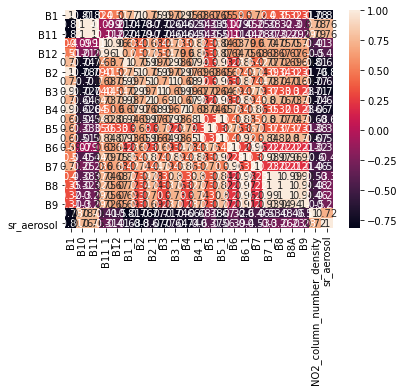

In [12]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

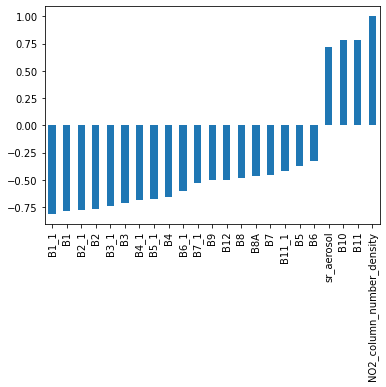

In [13]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [14]:
dtale.show(df)

In [15]:
df.isnull().sum()

B1                           0
B10                          0
B11                          0
B11_1                        0
B12                          0
B1_1                         0
B2                           0
B2_1                         0
B3                           0
B3_1                         0
B4                           0
B4_1                         0
B5                           0
B5_1                         0
B6                           0
B6_1                         0
B7                           0
B7_1                         0
B8                           0
B8A                          0
B9                           0
NO2_column_number_density    0
sr_aerosol                   0
dtype: int64

In [16]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
y=scaler.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [17]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values


scaler=MinMaxScaler()
X_sep=scaler.fit_transform(X_sep)
y_sep=scaler.fit_transform(y_sep.reshape(-1, 1))

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)


In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/250 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.09102928187168206

Generation 2 - Current best internal CV score: -0.09102928187168206


In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
#model.export('Combined_S2_LandSat8_S5_San_Francisco_TPOT_tpot_best_model.py')

In [ ]:
#from sklearn.ensemble import ExtraTreesRegressor
model = RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
model.fit(X_train, y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
NO2_column_number_density=df['NO2_column_number_density']

In [ ]:
X_all=X
all_prediction=model.predict(X_all)

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.plot(y,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [ ]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

In [ ]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
NO2_column_number_density=df['NO2_column_number_density']

In [ ]:
X_all=X
all_prediction=model.predict(X_all)

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.plot(y,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

In [ ]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [ ]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

# Linear Regression for Multioutput Regression

In [ ]:
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

##
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

# k-Nearest Neighbors for Multioutput Regression

In [ ]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train ,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

# Decision Tree for Multioutput Regression

In [ ]:
# define model
model = DecisionTreeRegressor(max_depth=8,
                           min_samples_split=5,
                           max_leaf_nodes=20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction)

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train ,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
y=scaler.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=15, max_features=0.9500000000000001,
                                min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))